In [1]:
import pybar.pybar_tom as pybar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
import pandas as pd
from tqdm import tqdm
import functions as f
from pathlib import Path

In [2]:
beta = np.deg2rad(50)
i    = np.deg2rad(50)
to_Myr = 9.78462

In [3]:
t = 20
X, Y, VX, VY, RHO = np.load(f'./../simulation/simulation/output_npy/data_{t}.npy')
FIG_DIR = Path('./../figures/')

In [4]:
VX, VY = f.add_solid_body_rotation(X, Y, VX, VY, 0.4)
X, Y, VX, VY = f.rotate_bar(beta, X, Y, VX, VY)
X, Y, VR = f.incline_galaxy(i, X, Y, VX, VY)

In [5]:
VR, RHO, X, Y = f.add_uncertanties(VR, RHO, X, Y, 0.1, 0.1 * RHO, 5)

### pixelation

In [6]:
step = 0.1
RHO_array          = f.mean_in_pixel(X, Y, step, RHO)
VR_array          = f.mean_in_pixel(X, Y, step, VR * RHO) / RHO_array

x_center_array, y_center_array = f.centers_of_pixel(X, Y, step)

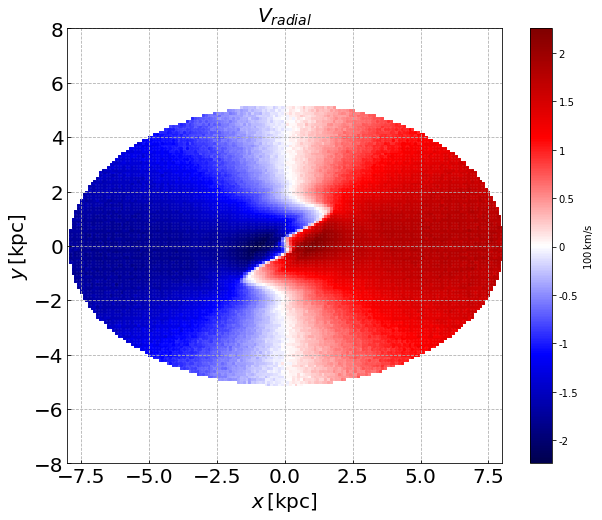

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

levels = np.linspace(np.nanmin(VR_array), np.nanmax(VR_array), 101)
norm = mc.BoundaryNorm(levels, 256)

sc = ax.scatter(x_center_array, y_center_array, c=VR_array, 
                cmap='seismic', marker='s', s=4)
ax.grid(ls='dashed')
ax.tick_params(labelsize=20, direction='in')
ax.set_xlabel(r'$x\, \rm [kpc]$', fontsize=20)
ax.set_ylabel(r'$y\, \rm [kpc]$', fontsize=20)
ax.set_ylim(-8, 8)
ax.set_xlim(-8, 8)
ax.set_aspect('1')
ax.set_title(r'$V_{radial}$', fontsize=20)
plt.colorbar(sc, format='%g', label=r'$\rm 100\, km/s$')
plt.savefig(FIG_DIR / f'VLOS_pixel_{np.round(np.rad2deg(i), 0)}_{np.round(np.rad2deg(beta), 0)}.png', 
            bbox_inches='tight', dpi=300)

### symmetrization and error calculation

In [8]:
VR_array = f.make_symmetric(x_center_array, VR_array)
RHO_array = f.make_symmetric(x_center_array, RHO_array)

In [9]:
SNratio = 10

VR_err_array = 0.1 * np.ones_like(VR_array)
RHO_err_array = RHO_array / SNratio

### integrating

In [10]:
bar = pybar.mybar(Flux=RHO_array, Flux_err=RHO_err_array,
                  Velocity=VR_array, Velocity_err=VR_err_array,
                  Yin=y_center_array, Xin = x_center_array,
                
                  inclin=np.rad2deg(i), PAnodes=-90)

In [11]:
bar.tremaine_weinberg(slit_width=step)

/opt/homebrew/lib/python3.9/site-packages/pybar/pybar_tom.py:522: RuntimeWarning: invalid value encountered in true_divide
  self.Omsini_tw = fluxVel_slit / fluxX_slit
/opt/homebrew/lib/python3.9/site-packages/pybar/pybar_tom.py:523: RuntimeWarning: invalid value encountered in true_divide
  self.dfV_tw = fluxVel_slit / flux_slit
/opt/homebrew/lib/python3.9/site-packages/pybar/pybar_tom.py:524: RuntimeWarning: invalid value encountered in true_divide
  self.dfx_tw = fluxX_slit / flux_slit
/opt/homebrew/lib/python3.9/site-packages/pybar/pybar_tom.py:529: RuntimeWarning: invalid value encountered in true_divide
  err_percentage_vel = err_fluxVel_slit / fluxVel_slit
/opt/homebrew/lib/python3.9/site-packages/pybar/pybar_tom.py:530: RuntimeWarning: invalid value encountered in true_divide
  err_percentage_flux = err_flux_slit / flux_slit


In [12]:
x_tw = bar.dfx_tw
v_tw = bar.dfV_tw

x_tw_err = bar.dfx_tw_err
v_tw_err = bar.dfV_tw_err

### fitting

In [13]:
omega_bar, omega_bar_err, c, c_err = f.odr_fit(x_tw, x_tw_err, v_tw, v_tw_err)

In [14]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021/bin/universal-darwin'
#print(os.getenv("PATH"))

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=True)

In [15]:
plasma = cm.get_cmap('plasma', len(x_tw))
colors = plasma.colors

x_fit = np.linspace(np.nanmin(x_tw), np.nanmax(x_tw), 3)
y_GT  = (x_fit * 40) * np.sin(i) + c * 100
y_fit = (x_fit * omega_bar * 100) + c * 100

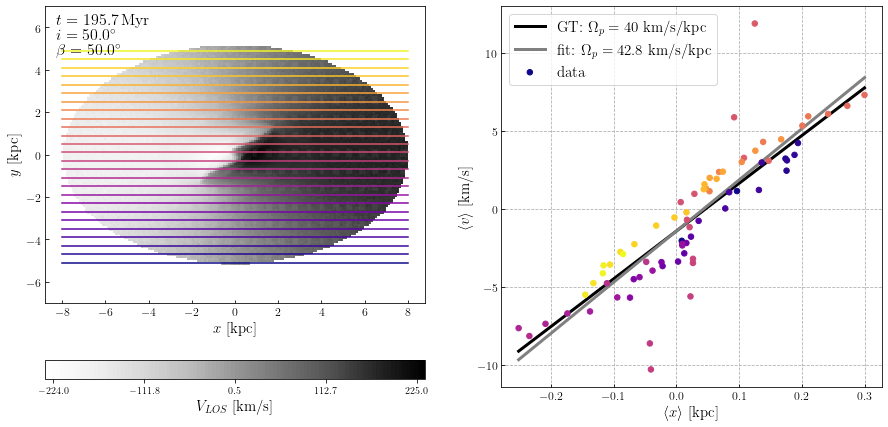

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

levels = np.linspace(np.nanmin(VR_array) * 100 - 10, np.nanmax(VR_array) * 100 + 10, 101)
cbarticks = np.linspace(np.nanmin(VR_array).round(2) * 100 , np.nanmax(VR_array).round(2) * 100 , 5)
norm = mc.BoundaryNorm(levels, 256)

ax1 = ax[0]
ax2 = ax[1]

sc = ax1.scatter(x_center_array, y_center_array, c=VR_array * 100, 
                 cmap='Greys', norm=norm, marker='s', s=3)
for index, y in enumerate(y_center_array[0,:-1]):
    if index % 4 == 0:
        ax1.plot([-8, 8], [y, y], c=colors[index])
ax1.set_xlabel(r'$x$ [kpc]', fontsize=15)
ax1.set_ylabel(r'$y$ [kpc]', fontsize=15)
ax1.tick_params(labelsize=12, direction='in')
ax1.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr), xy=(0.03, 0.94),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)), xy=(0.03, 0.89),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$\beta=%.1f ^{\circ}$' % (np.rad2deg(beta)), xy=(0.03, 0.84),
             xycoords='axes fraction', fontsize=16, color='k')

ax1.set_ylim(-7, 7)
cbar = plt.colorbar(sc, ax=ax1, orientation="horizontal", fraction=0.07, ticks=cbarticks)
cbar.set_label(label=r'$V_{LOS}$ [km/s]', size=15)

ax2.plot(x_fit, y_GT, 
        c='black', lw=3, label=r'GT: $\Omega_p = 40$ km/s/kpc')
ax2.plot(x_fit, y_fit, 
        c='gray', lw=3, label=fr'fit: $\Omega_p = {(omega_bar * 100 / np.sin(i)).round(1)}$ km/s/kpc')

ax2.scatter(x_tw, v_tw * 100, s=30, c=colors, label=r'data', zorder=100)

# ax2.set_ylim(-3, 3)
# ax2.set_xlim(-0.1, 0.1)
ax2.tick_params(labelsize=12,direction='in')
ax2.set_xlabel(r' $\langle x \rangle$ [kpc]', fontsize=15)
ax2.set_ylabel(r' $\langle v \rangle$ [km/s]', fontsize=15)
ax2.legend(fontsize=15, loc='upper left')
ax2.grid(ls='dashed')
plt.savefig(FIG_DIR / 'TW_method_pybar.png', bbox_inches='tight', dpi=300)